In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

In [3]:
vgg = tf.keras.applications.VGG16(
    input_shape=[100, 100, 3], include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [4]:
x = Flatten()(vgg.output)
x = Dense(4, activation='sigmoid')(x)
model = Model(vgg.input, x)

In [5]:
def image_generator(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, 100, 100, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # make the boxes and store their location in target
        row0 = np.random.randint(90)
        col0 = np.random.randint(90)
        row1 = np.random.randint(row0, 100)
        col1 = np.random.randint(col0, 100)
        X[i,row0:row1,col0:col1,:] = 1
        Y[i,0] = row0/100.
        Y[i,1] = col0/100.
        Y[i,2] = (row1 - row0)/100.
        Y[i,3] = (col1 - col0)/100.

      yield X, Y

In [8]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))

In [ ]:
model.fit(
    image_generator(),
    steps_per_epoch=50,
    epochs=5,
)

In [10]:
from matplotlib.patches import Rectangle

# Make predictions
def make_prediction():
  # Generate a random image
  x = np.zeros((100, 100, 3))
  row0 = np.random.randint(90)
  col0 = np.random.randint(90)
  row1 = np.random.randint(row0, 100)
  col1 = np.random.randint(col0, 100)
  x[row0:row1,col0:col1,:] = 1
  print(row0, col0, row1, col1)

  # Predict
  X = np.expand_dims(x, 0)
  p = model.predict(X)[0]

  # Draw the box
  fig, ax = plt.subplots(1)
  ax.imshow(x)
  rect = Rectangle(
      (p[1]*100, p[0]*100),
      p[3]*100, p[2]*100,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

6 77 48 78
1/1 [==============================] - 0s 293ms/step


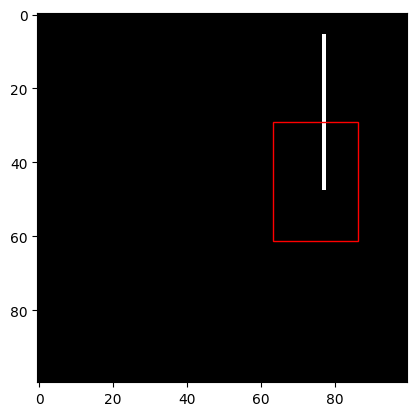

In [11]:
make_prediction()

In [12]:
from tensorflow.keras.preprocessing import image

In [13]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2024-05-07 09:58:01--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2024-05-07 09:58:02 (48.2 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



In [14]:
!ls

charmander-tight.png  sample_data


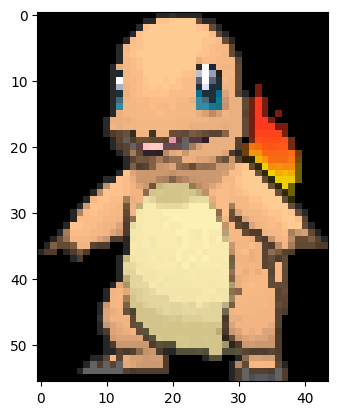

In [15]:
ch = image.load_img('charmander-tight.png')
plt.imshow(ch)
plt.show()

In [16]:
np.array(ch).shape

(56, 44, 3)

In [17]:
from imageio import imread

In [18]:
ch = imread('charmander-tight.png')

<ipython-input-18-c3c5b2ae7794>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ch = imread('charmander-tight.png')


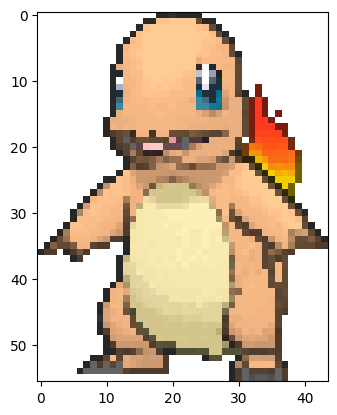

In [19]:
plt.imshow(ch)

In [20]:
type(ch)

numpy.ndarray

In [21]:
ch.shape

(56, 44, 4)

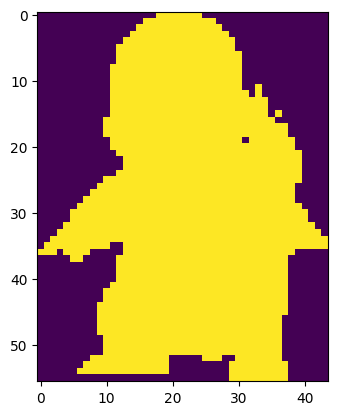

In [22]:
# What's in the 4th channel?
plt.imshow(ch[:,:,3])
plt.show()

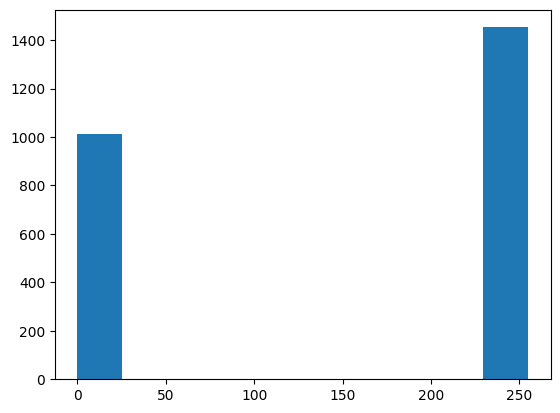

{0, 255}

In [23]:
plt.hist(ch[:,:,3].flatten())
plt.show()
set(ch[:,:,3].flatten())

In [24]:
POKE_DIM = 200
ch = np.array(ch)
CH_H, CH_W, _ = ch.shape

def pokemon_generator(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # choose location and store in target
        row0 = np.random.randint(POKE_DIM - CH_H)
        col0 = np.random.randint(POKE_DIM - CH_W)
        row1 = row0 + CH_H
        col1 = col0 + CH_W
        X[i,row0:row1,col0:col1,:] = ch[:,:,:3]
        Y[i,0] = row0/POKE_DIM
        Y[i,1] = col0/POKE_DIM

        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM

      yield X / 255., Y

In [25]:
def make_model():
  vgg = tf.keras.applications.VGG16(
    input_shape=[POKE_DIM, POKE_DIM, 3],
    include_top=False,
    weights='imagenet')
  x = Flatten()(vgg.output)
  x = Dense(4, activation='sigmoid')(x)
  model = Model(vgg.input, x)
#   model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9))
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
  return model

In [ ]:
model = make_model()
model.fit_generator(
    pokemon_generator(),
    steps_per_epoch=50,
    epochs=5,
)

In [26]:
# Make predictions
def pokemon_prediction():
  # Generate a random image
  x = np.zeros((POKE_DIM, POKE_DIM, 3))
  row0 = np.random.randint(POKE_DIM - CH_H)
  col0 = np.random.randint(POKE_DIM - CH_W)
  row1 = row0 + CH_H
  col1 = col0 + CH_W
  x[row0:row1,col0:col1,:] = ch[:,:,:3]
  print("true:", row0, col0, row1, col1)

  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]

  # Calculate target / loss
  y = np.zeros(4)
  y[0] = row0/POKE_DIM
  y[1] = col0/POKE_DIM
  y[2] = (row1 - row0)/POKE_DIM
  y[3] = (col1 - col0)/POKE_DIM

  # Draw the box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)
  print("pred:", row0, col0, row1, col1)
  print("loss:", -np.mean(y * np.log(p) + (1 - y)*np.log(1-p)))


  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

In [ ]:
pokemon_prediction()

In [27]:
from skimage.transform import resize

def pokemon_generator_with_resize(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # resize charmander - make it bigger or smaller
        scale = 0.5 + np.random.random() # [0.5, 1.5]
        new_height = int(CH_H * scale)
        new_width = int(CH_W * scale)
        obj = resize(
            ch,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8) # keep it from 0..255

        # choose location and store in target
        row0 = np.random.randint(POKE_DIM - new_height)
        col0 = np.random.randint(POKE_DIM - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width
        X[i,row0:row1,col0:col1,:] = obj[:,:,:3]
        Y[i,0] = row0/POKE_DIM
        Y[i,1] = col0/POKE_DIM

        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM

      yield X/255., Y

In [28]:
def make_model2():
  vgg = tf.keras.applications.VGG16(
    input_shape=[POKE_DIM, POKE_DIM, 3],
    include_top=False,
    weights='imagenet')
  x = Flatten()(vgg.output)
  x = Dense(4, activation='sigmoid')(x)
  model = Model(vgg.input, x)
#   model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9))
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001))
  return model

In [ ]:
model = make_model2()
model.fit(
    pokemon_generator_with_resize(),
    steps_per_epoch=50,
    epochs=5,
)

In [29]:
# Make predictions with resize
def pokemon_prediction_with_resize():
  # resize charmander - make it bigger or smaller
  scale = 0.5 + np.random.random()
  new_height = int(CH_H * scale)
  new_width = int(CH_W * scale)
  obj = resize(
      ch,
      (new_height, new_width),
      preserve_range=True).astype(np.uint8) # keep it from 0..255

  # Generate a random image
  x = np.zeros((POKE_DIM, POKE_DIM, 3))
  row0 = np.random.randint(POKE_DIM - new_height)
  col0 = np.random.randint(POKE_DIM - new_width)
  row1 = row0 + new_height
  col1 = col0 + new_width
  x[row0:row1,col0:col1,:] = obj[:,:,:3]
  print("true:", row0, col0, row1, col1)

  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]

  # Draw the box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)
  print("pred:", row0, col0, row1, col1)


  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

In [ ]:
pokemon_prediction_with_resize()

In [30]:
def pokemon_generator_flip(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # make the circles and store their location in target
        row0 = np.random.randint(POKE_DIM - CH_H)
        col0 = np.random.randint(POKE_DIM - CH_W)
        row1 = row0 + CH_H
        col1 = col0 + CH_W

        # maybe flip
        if np.random.random() < 0.5:
          obj = np.fliplr(ch)
        else:
          obj = ch

        X[i,row0:row1,col0:col1,:] = obj[:,:,:3]
        Y[i,0] = row0/POKE_DIM
        Y[i,1] = col0/POKE_DIM

        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM

      yield X / 255., Y

In [ ]:
model = make_model()
model.fit_generator(
    pokemon_generator_flip(),
    steps_per_epoch=50,
    epochs=5,
)

In [31]:
# Make predictions
def pokemon_prediction_flip():
  # Generate a random image
  x = np.zeros((POKE_DIM, POKE_DIM, 3))
  row0 = np.random.randint(POKE_DIM - CH_H)
  col0 = np.random.randint(POKE_DIM - CH_W)
  row1 = row0 + CH_H
  col1 = col0 + CH_W

  # maybe flip
  if np.random.random() < 0.5:
    obj = np.fliplr(ch)
  else:
    obj = ch

  x[row0:row1,col0:col1,:] = obj[:,:,:3]
  print("true:", row0, col0, row1, col1)

  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]

  # Draw the box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)
  print("pred:", row0, col0, row1, col1)


  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

In [ ]:
pokemon_prediction_flip()

In [32]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2024-05-07 09:58:46--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K  --.-KB/s    in 0.1s    

2024-05-07 09:58:46 (4.69 MB/s) - ‘backgrounds.zip’ saved [494000/494000]



In [ ]:
!unzip -n backgrounds.zip

In [34]:
from glob import glob
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for f in background_files:
  # Note: they may not all be the same size
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)

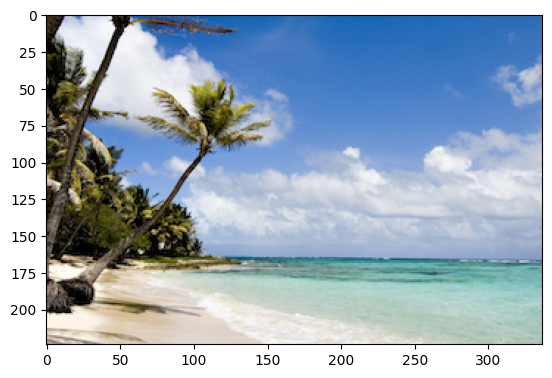

In [35]:
plt.imshow(backgrounds[3])

In [36]:
def pokemon_generator_bg(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # select a random background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()

        # resize charmander - make it bigger or smaller
        scale = 0.5 + np.random.random()
        new_height = int(CH_H * scale)
        new_width = int(CH_W * scale)
        obj = resize(
            ch,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8) # keep it from 0..255

        # maybe flip
        if np.random.random() < 0.5:
          obj = np.fliplr(obj)

        # choose a random location to store the object
        row0 = np.random.randint(POKE_DIM - new_height)
        col0 = np.random.randint(POKE_DIM - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width

        # can't 'just' assign obj to a slice of X
        # since the transparent parts will be black (0)
        mask = (obj[:,:,3] == 0) # find where the pokemon is 0
        bg_slice = X[i,row0:row1,col0:col1,:] # where we want to place `obj`
        bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
        bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
        X[i,row0:row1,col0:col1,:] = bg_slice # put the slice back

        # make targets
        Y[i,0] = row0/POKE_DIM
        Y[i,1] = col0/POKE_DIM

        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM

      yield X / 255., Y

In [37]:
xx = None
yy = None
for x, y in pokemon_generator_bg():
  xx, yy = x, y
  break

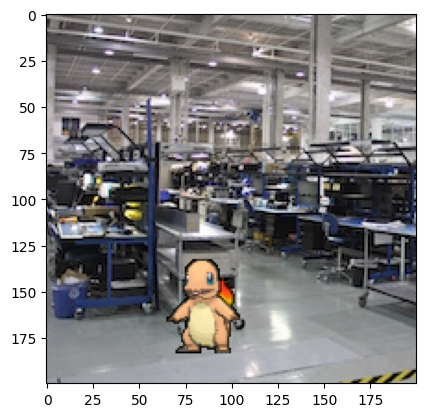

In [38]:
plt.imshow(xx[5]);

In [ ]:
model = make_model2()
model.fit(
    pokemon_generator_bg(),
    steps_per_epoch=50,
    epochs=5,
)

In [39]:
# Make predictions
def pokemon_prediction_bg():
  # select a random background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()

  # resize charmander - make it bigger or smaller
  scale = 0.5 + np.random.random()
  new_height = int(CH_H * scale)
  new_width = int(CH_W * scale)
  obj = resize(
      ch,
      (new_height, new_width),
      preserve_range=True).astype(np.uint8) # keep it from 0..255

  # maybe flip
  if np.random.random() < 0.5:
    obj = np.fliplr(obj)

  # choose a random location to store the object
  row0 = np.random.randint(POKE_DIM - new_height)
  col0 = np.random.randint(POKE_DIM - new_width)
  row1 = row0 + new_height
  col1 = col0 + new_width

  # can't 'just' assign obj to a slice of X
  # since the transparent parts will be black (0)
  mask = (obj[:,:,3] == 0) # find where the pokemon is 0
  bg_slice = x[row0:row1,col0:col1,:] # where we want to place `obj`
  bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
  bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
  x[row0:row1,col0:col1,:] = bg_slice # put the slice back
  print("true:", row0, col0, row1, col1)

  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]

  # Draw the box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)
  print("pred:", row0, col0, row1, col1)


  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

In [ ]:
pokemon_prediction_bg()

In [40]:
### next stage: have a binary flag where the object may or may not appear

In [41]:
### next stage: multiple pokemon

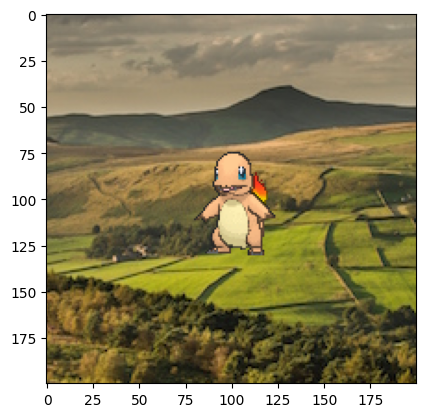

In [42]:
### won't work because you'll overwrite the background ###
# bg_idx = np.random.choice(len(backgrounds))
# print("bg_idx:", bg_idx)
bg_idx = 14
bg = backgrounds[bg_idx]
bg_h, bg_w, _ = bg.shape
# rnd_h = np.random.randint(bg_h - POKE_DIM)
# rnd_w = np.random.randint(bg_w - POKE_DIM)
# print("rnd_h:", rnd_h, "rnd_w:", rnd_w)
rnd_h = 5
rnd_w = 68
x = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()

# row0 = np.random.randint(POKE_DIM - CH_H)
# col0 = np.random.randint(POKE_DIM - CH_W)
row0 = 75
col0 = 80
row1 = row0 + CH_H
col1 = col0 + CH_W

# x[row0:row1,col0:col1,:] = ch[:,:,:3]

mask = (ch[:,:,3] == 0) # find where the pokemon is 0
bg_slice = x[row0:row1,col0:col1,:] # where we want to place `obj`
bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
bg_slice += ch[:,:,:3] # "add" the pokemon to the slice
x[row0:row1,col0:col1,:] = bg_slice # put the slice back

plt.imshow(x);